### Load libraries

In [1]:
# systemic libraries
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy
import scvi
import decoupler

# visualization
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


<i><b> Print the container version </b></i>

In [2]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-03-26


<i><b> Set the home directory </b></i>

In [3]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [4]:
with open("/image_version", "r") as f:
    image_name = f.readline().replace("\n", "")
image_name

'sddcunit/downstream:sc-1.1.0'

### Load the data

> *** NOTE: Hashed lines have been run before. 

In [5]:
# Load the individual datasets to extract sample_id information
#adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad")

### Data integration (Harmony)

In [6]:
# Define paths
adata_file = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration"
harmony_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration/integration_script.py"
sbatch_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration/run_integration.job"

In [7]:
# Write the integration script 
integration_script = f"""
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy

# Load the data
adata_name = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad"
adata = sc.read_h5ad(adata_name)

# Select the layer
adata.X = adata.layers['log_normalized_scaled_counts'].copy()

# Calculate the PCA 
sc. .pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 111)

# Run harmony
sce.pp.harmony_integrate(adata, key = 'dataset_of_origin', adjusted_basis='X_pca_harmony',
                         max_iter_harmony = 30)

# Save the data
adata.write_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated.h5ad")

"""
with open(harmony_script_path, "w") as f:
    f.write(integration_script)

In [8]:
# Write the bash script
sbatch_script = f"""#!/bin/bash
#SBATCH --time=24:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --gres=gpu:1
#SBATCH --partition=gpuq
#SBATCH --job-name=integration
#SBATCH --mem=64GB
#SBATCH --mail-type=END
#SBATCH --output=%x_%j.log

export SINGULARITY_CACHEDIR=/group/kalebic/Nikola/1_single_cell_final/Nikola_final/scmorpho/.singularity/
export SINGULARITY_TMPDIR=$TMPDIR

module load cuda11.1/toolkit/11.1.1
module load singularity
singularity exec --nv -H {home_path} \\
                 docker://{image_name} \\
                 python3 {os.path.abspath(harmony_script_path)}

"""

with open(sbatch_script_path, "w") as f:   
    f.write(sbatch_script)

### Neighboring and clustering

In [9]:
# Load the integrated data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated.h5ad")

In [10]:
# Compute the kNN graph
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=80, random_state = 111)

2025-03-26 17:31:04.112395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-26 17:31:04.112441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-26 17:31:04.112463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 17:31:05.103229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Compute the UMAP
sc.tl.umap(adata, random_state = 111)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


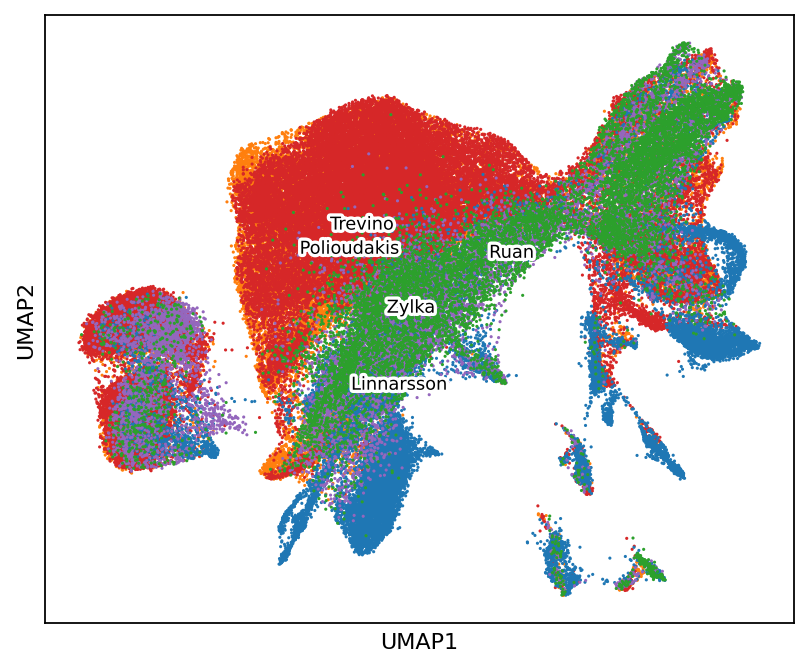

In [12]:
# Plot the UMAP
sc.set_figure_params(figsize=(6, 5))
ax = sc.pl.umap(adata, color=["dataset_of_origin"],frameon=True, show = False, legend_fontsize=8, size =8,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_dataset_of_origin.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [13]:
# Compute clusters
sc.tl.leiden(adata, key_added="X_leiden_harmony", resolution=0.4, random_state = 111)

In [14]:
# Rename the clusters
new_cluster_names = ['Early N. \n1', 'Early N. \n2', 'CRYM+ \nN1', 'SATB2+ \nN.', 'G1 RG', 'Cycling Pgs', 
                     'G1 IPs', 'IN 1', 'CTIP2+ \nN.', 'IN 2', 'Glia', 'Endothelial', 'Cajal-Retzius', 'Microglia', 'CRYM+ \nN2']

adata.rename_categories('X_leiden_harmony', new_cluster_names)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


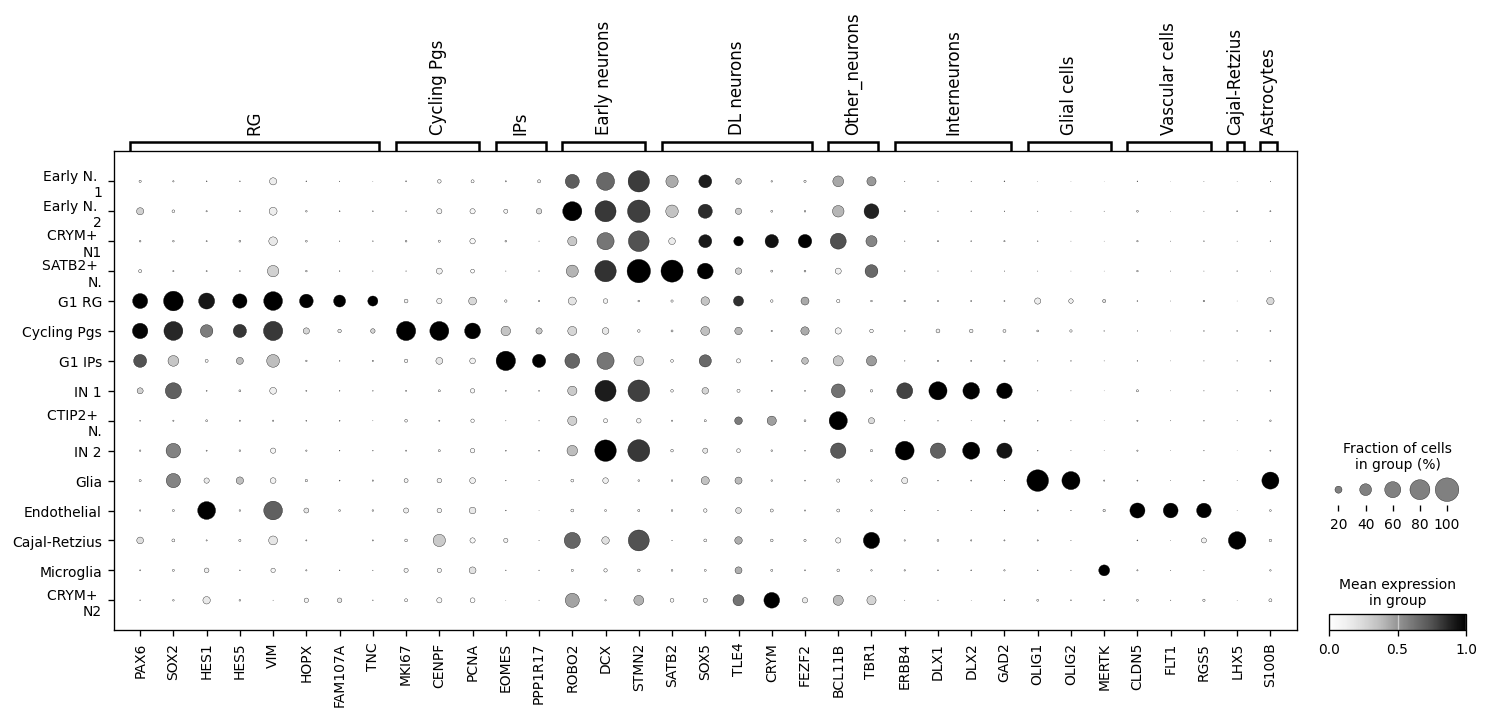

<Figure size 240x240 with 0 Axes>

In [15]:
# Plot the expression of marker genes across clusters
sc.set_figure_params(dpi = 60, dpi_save = 300, fontsize = 10)
markers = {'RG': ['PAX6', 'SOX2', 'HES1', 'HES5', 'VIM', 'HOPX', 'FAM107A', 'TNC'], 
           'Cycling Pgs': ['MKI67', 'CENPF', 'PCNA'],
           'IPs' : ['EOMES', 'PPP1R17'], 
           'Early neurons' : ['ROBO2','DCX', 'STMN2'],
           'DL neurons' : ['SATB2', 'SOX5', 'TLE4', 'CRYM', 'FEZF2'],
           'Other_neurons' : ['BCL11B', 'TBR1'],
           'Interneurons' : ['ERBB4', 'DLX1', 'DLX2', 'GAD2'],
           'Glial cells' : ['OLIG1', 'OLIG2', 'MERTK'],
           'Vascular cells': ['CLDN5', 'FLT1', 'RGS5'], 
           'Cajal-Retzius': ['LHX5'],
           'Astrocytes': ['S100B']
          }

sc.pl.dotplot(adata, markers, groupby ='X_leiden_harmony', mean_only_expressed = False, 
              show = True, standard_scale = 'var', cmap = 'Greys')

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_integrated_leiden_clusters.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


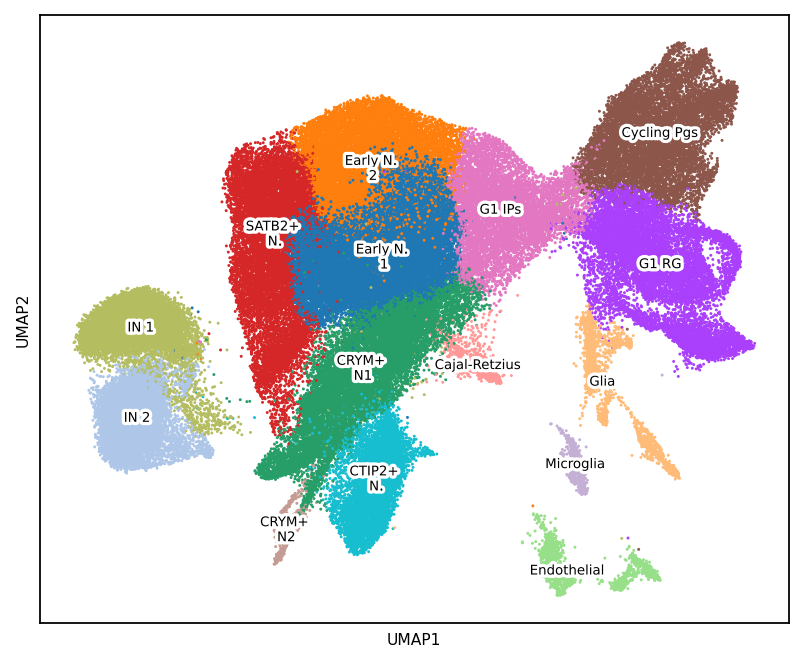

In [16]:
# Plot the UMAP
sc.set_figure_params(figsize=(6, 5))
ax = sc.pl.umap(adata, color=["X_leiden_harmony"],frameon=True, show = False, legend_fontsize=6, size =7,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=7)
ax.set_ylabel('UMAP2',fontsize=7)

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_leiden_clusters.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting

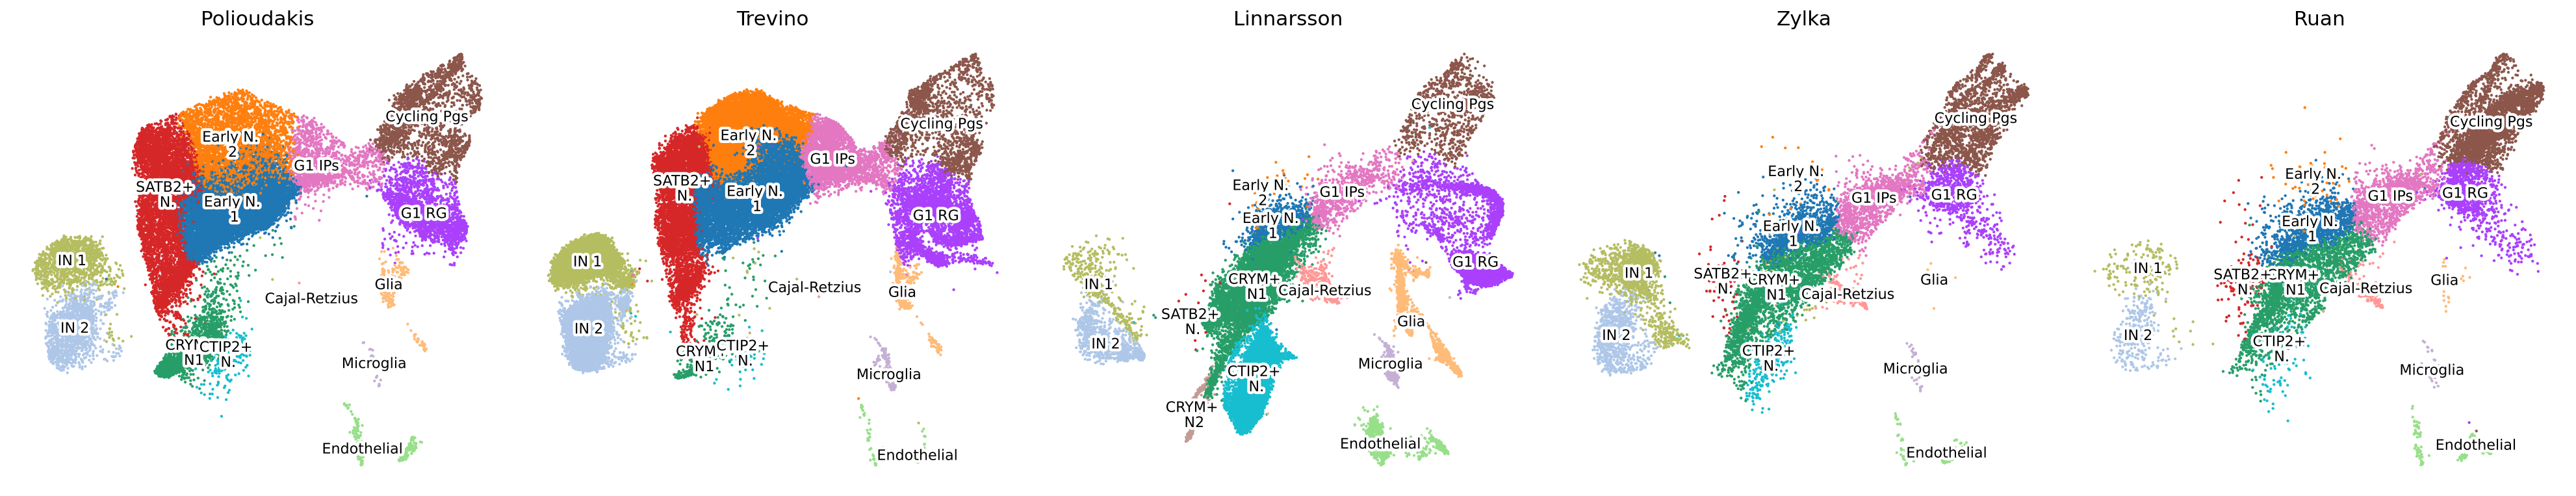

In [17]:
# Plot UMAPS prior to subclustering
fig, axes = plt.subplots(1, 5, figsize = (25, 5))
axes = axes.flatten()

for i,j in zip(adata.obs["dataset_of_origin"].unique().tolist(),axes.ravel()):
    ax = sc.pl.umap(adata[adata.obs["dataset_of_origin"].isin([i])],color=['X_leiden_harmony'], size=15, frameon=False,
                    show=False,ax=j, legend_loc = "on data", legend_fontsize=10, legend_fontweight=4, legend_fontoutline = 4)
    ax.set_title(i)
    
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_leiden_clusters_per_dataset.svg', dpi = 300, bbox_inches = 'tight')
plt.show() 

In [18]:
#sc.set_figure_params(dpi = 80, figsize = (4.5, 3.5))
# Build the crosstab dataframe
#cross_plt = pd.crosstab(adata.obs['X_leiden_harmony'],adata.obs['dataset_of_origin'], normalize='columns')*100
#
# Reorder the clusters
#ordered_clusters = ['G1 RG', 'G1 IPs', 'Cycling Pgs', 'Glia', 'Early N. \n1', 'Early N. \n2', 'Cajal-Retzius', 
#                    'CTIP2+ \nN.', 'SATB2+ \nN.', 'CRYM+ \nN1', 'CRYM+ \nN2',  'IN 1',  'IN 2', 'Endothelial', 
#                    'Microglia']
#
# Plot the stacked-bar graph
#cross_plt_reindexed = cross_plt.reindex(ordered_clusters)
#ax = cross_plt_reindexed.T.plot(kind='bar', stacked=True, colormap='tab20b', width=0.8)
#ax.legend(title="", bbox_to_anchor=(1.18, 1.0), loc='upper center', fontsize = 8)
#ax.tick_params(axis='x', labelrotation=45)
#ax.set(xlabel=None)
#ax.set_title('Cluster distribution across GW', loc = 'center', fontsize = 12)
#ax.grid(False)
#ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize = 10, rotation = 0)
#ax.set_xticklabels(['mDG', 'hNcx \n[GW 17-18]', 'mNcx_R', 'hNcx \n[GW 16-24]', 'mNcx_Z'], fontsize = 8, rotation = 0)
#
#for rec in ax.patches:
#    height = rec.get_height()
#    if height > 3:
#        ax.text(rec.get_x() + rec.get_width() / 1.9, 
#                rec.get_y() + height / 5.5,
#                "{:.1f}%".format(height),
#                ha='center', 
#                va='bottom', 
#                fontsize = 8)
#
#ax.legend(fontsize = 6, bbox_to_anchor = (1.02, 0.96))
#plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/plots/clustering/Cluster_distribution.png', dpi = 300, bbox_inches = 'tight')
#plt.show()